# Analysis of Lag Hours from Pedestrian Fatalities

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


import time

# Statistical Models
import lifelines

# Machine learning models
import xgboost as xgb
from sklearn import linear_model
from sklearn.tree import DecisionTreeRegressor
#from sklearn.tree import ExtraTreeRegressor  # Don't use this as it should be only used within an ensemble method
from sklearn.ensemble import ExtraTreesRegressor 
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import RANSACRegressor
from sklearn.neural_network import MLPRegressor

from xgbse import XGBSEKaplanNeighbors    # pip install xgbse
from xgbse.converters import convert_to_structured

import shap

from sksurv.ensemble import RandomSurvivalForest

# Data processing and evaluation metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import get_scorer_names  # to get avaiable scorers


# Cross-validation
from sklearn.model_selection import GridSearchCV 

# Lifelines documentation: https://lifelines.readthedocs.io/en/latest/Quickstart.html

In [3]:
df = pd.read_csv("df_VRU_fatal_model_R.csv")

In [331]:
df['LAG_HRS'].describe()

count    33615.000000
mean        24.644742
std         82.281698
min          0.000000
25%          0.000000
50%          0.000000
75%          2.000000
max        720.000000
Name: LAG_HRS, dtype: float64

In [4]:
print(df.shape)
print(df.columns)

(33615, 28)
Index(['Index', 'Year_STCASE', 'YEAR', 'ST_CASE', 'VEH_NO', 'PER_NO',
       'LATITUDE', 'LONGITUDE', 'RUR_URBx', 'WEATHERx', 'Age_grp_driver',
       'A_ALDR', 'A_HR', 'A_LT', 'VRU_AGE_GRP', 'SEX', 'PBCWALK', 'PBSWALK',
       'VRU_intersection', 'LGT_x', 'A_SPCRA', 'RACE_VRU_x', 'Hospital_nearby',
       'Fire_station_nearby', 'VRU_AL', 'LAG_HRS', 'LAG_HRS_y',
       'Instant_death'],
      dtype='object')


Text(0.5, 0, 'Lag Hours (hours)')

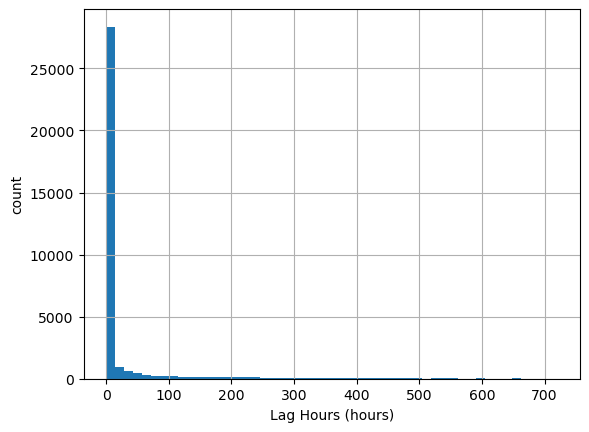

In [334]:
df['LAG_HRS'].hist(bins = 50)
plt.ylabel("count")
plt.xlabel("Lag Hours (hours)")

In [336]:
df[df['LAG_HRS']==0].shape

(22788, 28)

Text(0.5, 0, 'Lag Hours (hours)')

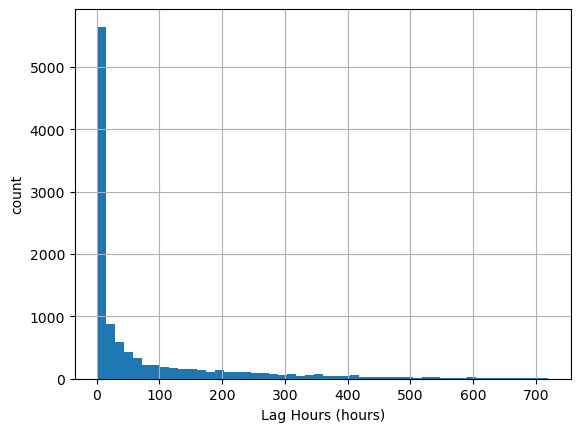

In [335]:
#df['LAG_HRS'].hist(bins = 50)
df[df['LAG_HRS']>0]['LAG_HRS'].hist(bins = 50)
plt.ylabel("count")
plt.xlabel("Lag Hours (hours)")

In [339]:
df['Fire_station_nearby'].value_counts()

0.0    19068
1.0    14547
Name: Fire_station_nearby, dtype: int64

'\nThe curve illustrates how the survival probabilities changes over the time horizon. \nAs the time passes, the survival probabilities of lung cancer patents reduces.\n'

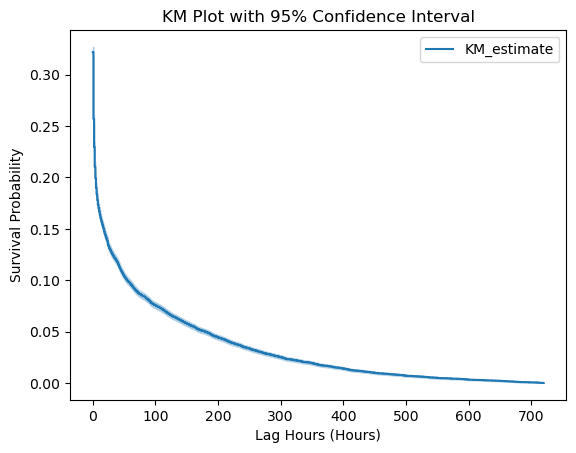

In [18]:
# Kaplan-Meier curve
kmf = lifelines.KaplanMeierFitter()
kmf.fit(durations = df['LAG_HRS'])
#kmf.fit(durations = df[df['LAG_HRS']>0]['LAG_HRS'])
kmf.plot_survival_function()
plt.xlabel("Lag Hours (Hours)")
plt.ylabel("Survival Probability")
plt.title("KM Plot with 95% Confidence Interval")

# Source: https://medium.com/the-researchers-guide/survival-analysis-in-python-km-estimate-cox-ph-and-aft-model-5533843c5d5d
'''
The curve illustrates how the survival probabilities changes over the time horizon. 
As the time passes, the survival probabilities of patient reduces.
'''

In [4]:
# Accelerated Failure Time (AFT) model for result comparison

# Create dummies for the following columns:
# 'WEATHERx', 'Age_grp_driver',VRU_AGE_GRP','LGT_x','RACE_VRU_x'

dummies_WEATHERx = pd.get_dummies(df['WEATHERx'], prefix = 'WEATHERx')
dummies_WEATHERx = dummies_WEATHERx.drop(columns=dummies_WEATHERx.columns[0], axis=1) 
# Create n-1 dummies by dropping the base column. Usually the base column is the first column
dummies_WEATHERx.head(4)

dummies_Age_grp_driver = pd.get_dummies(df['Age_grp_driver'], prefix = 'Age_grp_driver')
dummies_Age_grp_driver = dummies_Age_grp_driver.drop(columns=dummies_Age_grp_driver.columns[0], axis=1) 
dummies_Age_grp_driver.head(4)

dummies_VRU_AGE_GRP = pd.get_dummies(df['VRU_AGE_GRP'], prefix = 'VRU_AGE_GRP')
dummies_VRU_AGE_GRP = dummies_VRU_AGE_GRP.drop(columns=dummies_VRU_AGE_GRP.columns[0], axis=1) 
dummies_VRU_AGE_GRP.head(4)

dummies_LGT_x = pd.get_dummies(df['LGT_x'], prefix = 'LGT_x')
dummies_LGT_x = dummies_LGT_x.drop(columns=dummies_LGT_x.columns[0], axis=1) 
dummies_LGT_x.head(4)

dummies_RACE_VRU_x = pd.get_dummies(df['RACE_VRU_x'], prefix = 'RACE_VRU_x')
dummies_RACE_VRU_x = dummies_RACE_VRU_x.drop(columns=dummies_RACE_VRU_x.columns[0], axis=1) 
dummies_RACE_VRU_x.head(4)

# Source: https://sparkbyexamples.com/pandas/pandas-drop-first-column-from-dataframe/

,RACE_VRU_x_1,RACE_VRU_x_2
0,1,0
1,0,0
2,0,0
3,0,0


In [19]:
df.columns

Index(['Index', 'Year_STCASE', 'YEAR', 'ST_CASE', 'VEH_NO', 'PER_NO',
       'LATITUDE', 'LONGITUDE', 'RUR_URBx', 'WEATHERx', 'Age_grp_driver',
       'A_ALDR', 'A_HR', 'A_LT', 'VRU_AGE_GRP', 'SEX', 'PBCWALK', 'PBSWALK',
       'VRU_intersection', 'LGT_x', 'A_SPCRA', 'RACE_VRU_x', 'Hospital_nearby',
       'Fire_station_nearby', 'VRU_AL', 'LAG_HRS', 'LAG_HRS_y',
       'Instant_death'],
      dtype='object')

In [5]:
# Adding the dummy columns
df2 = pd.concat([df, dummies_WEATHERx, dummies_Age_grp_driver, dummies_VRU_AGE_GRP, dummies_LGT_x, dummies_RACE_VRU_x], 
                axis = 1)
print(df.shape)
print(df2.shape)
df2.isnull().sum()

# Dropping the original columns because we already got dummies
df2 = df2.drop(columns=['WEATHERx', 'Age_grp_driver','VRU_AGE_GRP','LGT_x','RACE_VRU_x'])
df2.shape
# data = pd.concat([data, dummies_ecog], axis = 1)

(33615, 28)
(33615, 39)


(33615, 34)

In [48]:
df2.columns

Index(['Index', 'Year_STCASE', 'YEAR', 'ST_CASE', 'VEH_NO', 'PER_NO',
       'LATITUDE', 'LONGITUDE', 'RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBCWALK', 'PBSWALK', 'VRU_intersection', 'A_SPCRA', 'Hospital_nearby',
       'Fire_station_nearby', 'VRU_AL', 'LAG_HRS', 'LAG_HRS_y',
       'Instant_death', 'WEATHERx_1', 'WEATHERx_2', 'Age_grp_driver_1',
       'Age_grp_driver_2', 'VRU_AGE_GRP_1', 'VRU_AGE_GRP_2', 'VRU_AGE_GRP_3',
       'LGT_x_1', 'LGT_x_2', 'RACE_VRU_x_1', 'RACE_VRU_x_2'],
      dtype='object')

In [6]:
# drop the unnecessary columns
df3 = df2[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBCWALK', 'PBSWALK', 'VRU_intersection', 'A_SPCRA', 'Hospital_nearby',
       'Fire_station_nearby', 'LAG_HRS',
       'WEATHERx_1', 'WEATHERx_2', 'Age_grp_driver_1',
       'Age_grp_driver_2', 'VRU_AGE_GRP_1', 'VRU_AGE_GRP_2', 'VRU_AGE_GRP_3',
       'LGT_x_1', 'LGT_x_2', 'RACE_VRU_x_1', 'RACE_VRU_x_2']]
df3['status'] = 1
df3.loc[df3['LAG_HRS']==720,'status'] = 0
df3 = df3[df3['LAG_HRS']>0]


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [7]:
# Fitting Cox P-H model
cph = lifelines.CoxPHFitter()
#cph.fit(df2, duration_col = 'time', event_col = 'status')
#cph.fit(df3[df3['LAG_HRS']>0], duration_col = 'LAG_HRS')
cph.fit(df3, duration_col = 'LAG_HRS', event_col = 'status')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 10827 total observations, 1 right-censored observations>
             duration col = 'LAG_HRS'
                event col = 'status'
      baseline estimation = breslow
   number of observations = 10827
number of events observed = 10826
   partial log-likelihood = -89572.38
         time fit was run = 2023-05-02 14:34:43 UTC

---
                      coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
covariate                                                                                                                   
RUR_URBx             -0.18       0.84       0.03            -0.23            -0.12                 0.79                 0.89
A_ALDR                0.06       1.06       0.03             0.00             0.11                 1.00                 1.12
A_HR                  0.06       1.06       0.03             0.00             0.11                 1.00                 1.12
A_LT                  0.30       1.34       0.04             0.21             0.38                 1.24                 1.46
SEX                   0.12       1.13       0.02             0.08             0.16                 1.08                 1.17
PBCWALK              -0.00       1.00       0.03            -0.06             0.05                 0.94                 1.05
PBSWALK              -0.04       0.96       0.02            -0.08             0.00                 0.92                 1.00
VRU_intersection     -0.04       0.97       0.02            -0.08             0.01                 0.92                 1.01
A_SPCRA               0.11       1.12       0.04             0.04             0.19                 1.04                 1.20
Hospital_nearby       0.03       1.03       0.03            -0.02             0.09                 0.98                 1.09
Fire_station_nearby  -0.08       0.92       0.02            -0.12            -0.04                 0.89                 0.96
WEATHERx_1            0.01       1.01       0.03            -0.05             0.06                 0.95                 1.06
WEATHERx_2           -0.08       0.92       0.03            -0.14            -0.02                 0.87                 0.98
Age_grp_driver_1     -0.03       0.97       0.03            -0.08             0.02                 0.92                 1.02
Age_grp_driver_2      0.01       1.01       0.04            -0.06             0.08                 0.94                 1.08
VRU_AGE_GRP_1        -0.23       0.79       0.05            -0.33            -0.13                 0.72                 0.88
VRU_AGE_GRP_2        -0.32       0.72       0.04            -0.41            -0.24                 0.66                 0.79
VRU_AGE_GRP_3        -0.41       0.66       0.05            -0.50            -0.32                 0.61                 0.73
LGT_x_1               0.03       1.03       0.02            -0.01             0.08                 0.99                 1.08
LGT_x_2               0.15       1.17       0.03             0.10             0.21                 1.10                 1.23
RACE_VRU_x_1         -0.03       0.97       0.03            -0.09             0.02                 0.92                 1.02
RACE_VRU_x_2          0.07       1.08       0.03             0.02             0.12                 1.03                 1.13

                      cmp to     z      p   -log2(p)
covariate                                           
RUR_URBx                0.00 -6.23 <0.005      30.99
A_ALDR                  0.00  2.07   0.04       4.69
A_HR                    0.00  2.13   0.03       4.91
A_LT                    0.00  6.91 <0.005      37.59
SEX                     0.00  5.52 <0.005      24.81
PBCWALK                 0.00 -0.08   0.94       0.09
PBSWALK                 0.00 -1.83   0.07       3.90
VRU_intersection        0.00 -1.45   0.15       2.77
A_SPCRA                 0.00  2.91 <0.005       8.13
Hospital_nearby         0.00  1.30   0.19       2

In [92]:
# AFT models

# Instantiate each fitter
wb = lifelines.WeibullFitter()
ex = lifelines.ExponentialFitter()
lognormal = lifelines.LogNormalFitter()
loglogis = lifelines.LogLogisticFitter()



# Fit to data
for model in [wb, ex, lognormal, loglogis]:
    model.fit(durations = df3['LAG_HRS'], event_observed = df3["status"])
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)
    #print("The BIC value for", model.__class__.__name__, "is",  model.BIC_)




The AIC value for WeibullFitter is 104854.1465909397
The AIC value for ExponentialFitter is 115571.39726595872
The AIC value for LogNormalFitter is 103677.10162024685
The AIC value for LogLogisticFitter is 104769.88117714785


In [8]:
# Actual AFT models:
# LogLogisticAFTFitter, LogNormalAFTFitter, WeibullAFTFitter

# Instantiate each fitter
wbAFT = lifelines.WeibullAFTFitter()
lognormalAFT = lifelines.LogNormalAFTFitter()
loglogisAFT = lifelines.LogLogisticAFTFitter()

# Fit to data
for model in [wbAFT, lognormalAFT, loglogisAFT]:
    model.fit(df3, duration_col='LAG_HRS', event_col = 'status')
    # Print AIC
    print("The AIC value for", model.__class__.__name__, "is",  model.AIC_)
    print("The BIC value for", model.__class__.__name__, "is",  model.BIC_)

The AIC value for WeibullAFTFitter is 104478.9261312739
The BIC value for WeibullAFTFitter is 104449.50572786052
The AIC value for LogNormalAFTFitter is 103271.72919413875
The BIC value for LogNormalAFTFitter is 103242.30879072538
The AIC value for LogLogisticAFTFitter is 104294.85369864033
The BIC value for LogLogisticAFTFitter is 104265.43329522696


In [9]:
# Run the best fit AFT model using all variables (both significant and non significant)
lognormalAFT.fit(df3, duration_col='LAG_HRS', event_col = 'status')
lognormalAFT.print_summary(3)

<lifelines.LogNormalAFTFitter: fitted with 10827 total observations, 1 right-censored observations>
             duration col = 'LAG_HRS'
                event col = 'status'
   number of observations = 10827
number of events observed = 10826
           log-likelihood = -51611.865
         time fit was run = 2023-05-02 14:36:27 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                   
mu_    A_ALDR              -0.138      0.871      0.058           -0.250           -0.025                0.779                0.975
       A_HR                -0.147      0.863      0.054           -0.254           -0.041                0.776                0.960
       A_LT                -0.644      0.525      0.086           -0.814           -0.475                0.443                0.622
       A_SPCRA             -0.285      0.752      0.077           -0.435           -0.134                0.648                0.874
       Age_grp_driver_1     0.051      1.052      0.053           -0.053            0.155                0.949                1.167
       Age_grp_driver_2    -0.029      0.971      0.072           -0.171            0.113                0.843                1.119
       Fire_station_nearby  0.157      1.170      0.041            0.076            0.237                1.079                1.268
       Hospital_nearby      0.003      1.003      0.053           -0.100            0.107                0.904                1.113
       LGT_x_1             -0.111      0.895      0.047           -0.204           -0.018                0.815                0.982
       LGT_x_2             -0.386      0.680      0.057           -0.497           -0.274                0.608                0.760
       PBCWALK              0.039      1.040      0.057           -0.073            0.151                0.929                1.163
       PBSWALK              0.118      1.125      0.045            0.030            0.206                1.030                1.228
       RACE_VRU_x_1         0.002      1.002      0.056           -0.109            0.112                0.897                1.119
       RACE_VRU_x_2        -0.198      0.820      0.051           -0.297           -0.099                0.743                0.906
       RUR_URBx             0.423      1.527      0.057            0.311            0.536                1.364                1.709
       SEX                 -0.276      0.759      0.043           -0.360           -0.191                0.698                0.826
       VRU_AGE_GRP_1        0.486      1.626      0.105            0.280            0.692                1.323                1.997
       VRU_AGE_GRP_2        0.494      1.640      0.089            0.321            0.668                1.378                1.951
       VRU_AGE_GRP_3        0.596      1.814      0.093            0.413            0.778                1.511                2.177
       VRU_intersection     0.118      1.125      0.050            0.021            0.215                1.021                1.240
       WEATHERx_1          -0.018      0.982      0.056           -0.128            0.093                0.880                1.097
       WEATHERx_2           0.114      1.121      0.064           -0.011            0.240                0.989                1.271
       Intercept            1.928      6.873      0.107            1.718            2.137                5.574                8.475
sigma_ Intercept            0.704      2.021      0.007            0.690            0.717                1.995                2.049

                             cmp to       z       p   -log2(p)
param  covariate                                              
mu_    A_ALDR                 0.000  -2.392   0.017      5.898
       A_HR                   0.000  -2

In [101]:
print(lognormalAFT.AIC_)
print(lognormalAFT.BIC_)

103271.72919413875
103242.30879072538


In [11]:
lognormalAFT.params_

param   covariate          
mu_     A_ALDR                -0.137568
        A_HR                  -0.147100
        A_LT                  -0.644334
        A_SPCRA               -0.284517
        Age_grp_driver_1       0.051157
        Age_grp_driver_2      -0.029297
        Fire_station_nearby    0.156900
        Hospital_nearby        0.003165
        LGT_x_1               -0.111185
        LGT_x_2               -0.385710
        PBCWALK                0.038815
        PBSWALK                0.117680
        RACE_VRU_x_1           0.001739
        RACE_VRU_x_2          -0.197917
        RUR_URBx               0.423273
        SEX                   -0.275507
        VRU_AGE_GRP_1          0.485865
        VRU_AGE_GRP_2          0.494460
        VRU_AGE_GRP_3          0.595525
        VRU_intersection       0.117703
        WEATHERx_1            -0.017657
        WEATHERx_2             0.114492
        Intercept              1.927612
sigma_  Intercept              0.703805
dtype: float

In [103]:
# Run the best fit AFT model using only significant variables

# drop the unnecessary columns
df3 = df2[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA',
       'Fire_station_nearby', 'LAG_HRS',
       'WEATHERx_2', 'VRU_AGE_GRP_1', 'VRU_AGE_GRP_2', 'VRU_AGE_GRP_3',
       'LGT_x_1', 'LGT_x_2', 'RACE_VRU_x_2']]
df3['status'] = 1
df3.loc[df3['LAG_HRS']==720,'status'] = 0
df3 = df3[df3['LAG_HRS']>0]

lognormalAFT.fit(df3, duration_col='LAG_HRS', event_col = 'status')
lognormalAFT.print_summary(3)

C:\Users\User\AppData\Local\Temp\ipykernel_7588\3326054081.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3['status'] = 1


<lifelines.LogNormalAFTFitter: fitted with 10827 total observations, 1 right-censored observations>
             duration col = 'LAG_HRS'
                event col = 'status'
   number of observations = 10827
number of events observed = 10826
           log-likelihood = -51613.315
         time fit was run = 2023-04-29 22:07:25 UTC

---
                             coef  exp(coef)   se(coef)   coef lower 95%   coef upper 95%  exp(coef) lower 95%  exp(coef) upper 95%
param  covariate                                                                                                                   
mu_    A_ALDR              -0.136      0.873      0.057           -0.249           -0.024                0.780                0.977
       A_HR                -0.136      0.873      0.054           -0.242           -0.031                0.785                0.970
       A_LT                -0.638      0.529      0.086           -0.807           -0.469                0.446                0.626
       A_SPCRA             -0.288      0.749      0.076           -0.438           -0.139                0.645                0.870
       Fire_station_nearby  0.159      1.172      0.041            0.079            0.239                1.082                1.270
       LGT_x_1             -0.109      0.896      0.047           -0.202           -0.017                0.817                0.983
       LGT_x_2             -0.386      0.680      0.057           -0.497           -0.275                0.608                0.759
       PBSWALK              0.126      1.134      0.043            0.041            0.211                1.041                1.235
       RACE_VRU_x_2        -0.196      0.822      0.049           -0.293           -0.099                0.746                0.906
       RUR_URBx             0.425      1.529      0.057            0.313            0.537                1.367                1.711
       SEX                 -0.275      0.760      0.043           -0.359           -0.191                0.698                0.826
       VRU_AGE_GRP_1        0.487      1.627      0.105            0.281            0.692                1.324                1.998
       VRU_AGE_GRP_2        0.496      1.643      0.088            0.323            0.670                1.381                1.954
       VRU_AGE_GRP_3        0.596      1.815      0.092            0.415            0.778                1.515                2.176
       VRU_intersection     0.133      1.143      0.044            0.048            0.219                1.049                1.245
       WEATHERx_2           0.119      1.126      0.063           -0.006            0.243                0.994                1.275
       Intercept            1.950      7.031      0.098            1.758            2.143                5.800                8.524
sigma_ Intercept            0.704      2.022      0.007            0.691            0.717                1.995                2.049

                             cmp to       z       p   -log2(p)
param  covariate                                              
mu_    A_ALDR                 0.000  -2.374   0.018      5.828
       A_HR                   0.000  -2.531   0.011      6.459
       A_LT                   0.000  -7.393 <0.0005     42.659
       A_SPCRA                0.000  -3.778 <0.0005     12.625
       Fire_station_nearby    0.000   3.902 <0.0005     13.354
       LGT_x_1                0.000  -2.315   0.021      5.600
       LGT_x_2                0.000  -6.830 <0.0005     36.782
       PBSWALK                0.000   2.894   0.004      8.041
       RACE_VRU_x_2           0.000  -3.965 <0.0005     13.733
       RUR_URBx               0.000   7.423 <0.0005     42.985
       SEX                    0.000  -6.392 <0.0005     32.510
       VRU_AGE_GRP_1          0.000   4.636 <0.0005     18.100
       VRU_AGE_GRP_2          0.000   5.609 <0.0005     25.546
       VRU_AGE_GRP_3          0.000   6.448 <0.0005     33.040
       VRU_i

Machine learning

In [5]:
# survival analysis using xgboost
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error as MAE

In [5]:
df.columns

Index(['Index', 'Year_STCASE', 'YEAR', 'ST_CASE', 'VEH_NO', 'PER_NO',
       'LATITUDE', 'LONGITUDE', 'RUR_URBx', 'WEATHERx', 'Age_grp_driver',
       'A_ALDR', 'A_HR', 'A_LT', 'VRU_AGE_GRP', 'SEX', 'PBCWALK', 'PBSWALK',
       'VRU_intersection', 'LGT_x', 'A_SPCRA', 'RACE_VRU_x', 'Hospital_nearby',
       'Fire_station_nearby', 'VRU_AL', 'LAG_HRS', 'LAG_HRS_y',
       'Instant_death'],
      dtype='object')

In [8]:
'''
df4 = df[['RUR_URBx', 'WEATHERx', 'Age_grp_driver',
       'A_ALDR', 'A_HR', 'A_LT', 'VRU_AGE_GRP', 'SEX', 'PBCWALK', 'PBSWALK',
       'VRU_intersection', 'LGT_x', 'A_SPCRA', 'RACE_VRU_x', 'Hospital_nearby',
       'Fire_station_nearby', 'VRU_AL', 'LAG_HRS']]
'''

df4 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']]


print(df.shape)
'''
df4['status'] = 1
df4.loc[df4['LAG_HRS']==720,'status'] = 0
df4 = df4[df4['LAG_HRS']>0]
'''
df4.columns


(33615, 28)


Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x', 'LAG_HRS'],
      dtype='object')

In [9]:
X = df4.iloc[:, :-1].to_numpy()
y = df4.iloc[:, -1].to_numpy()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123, shuffle = True)

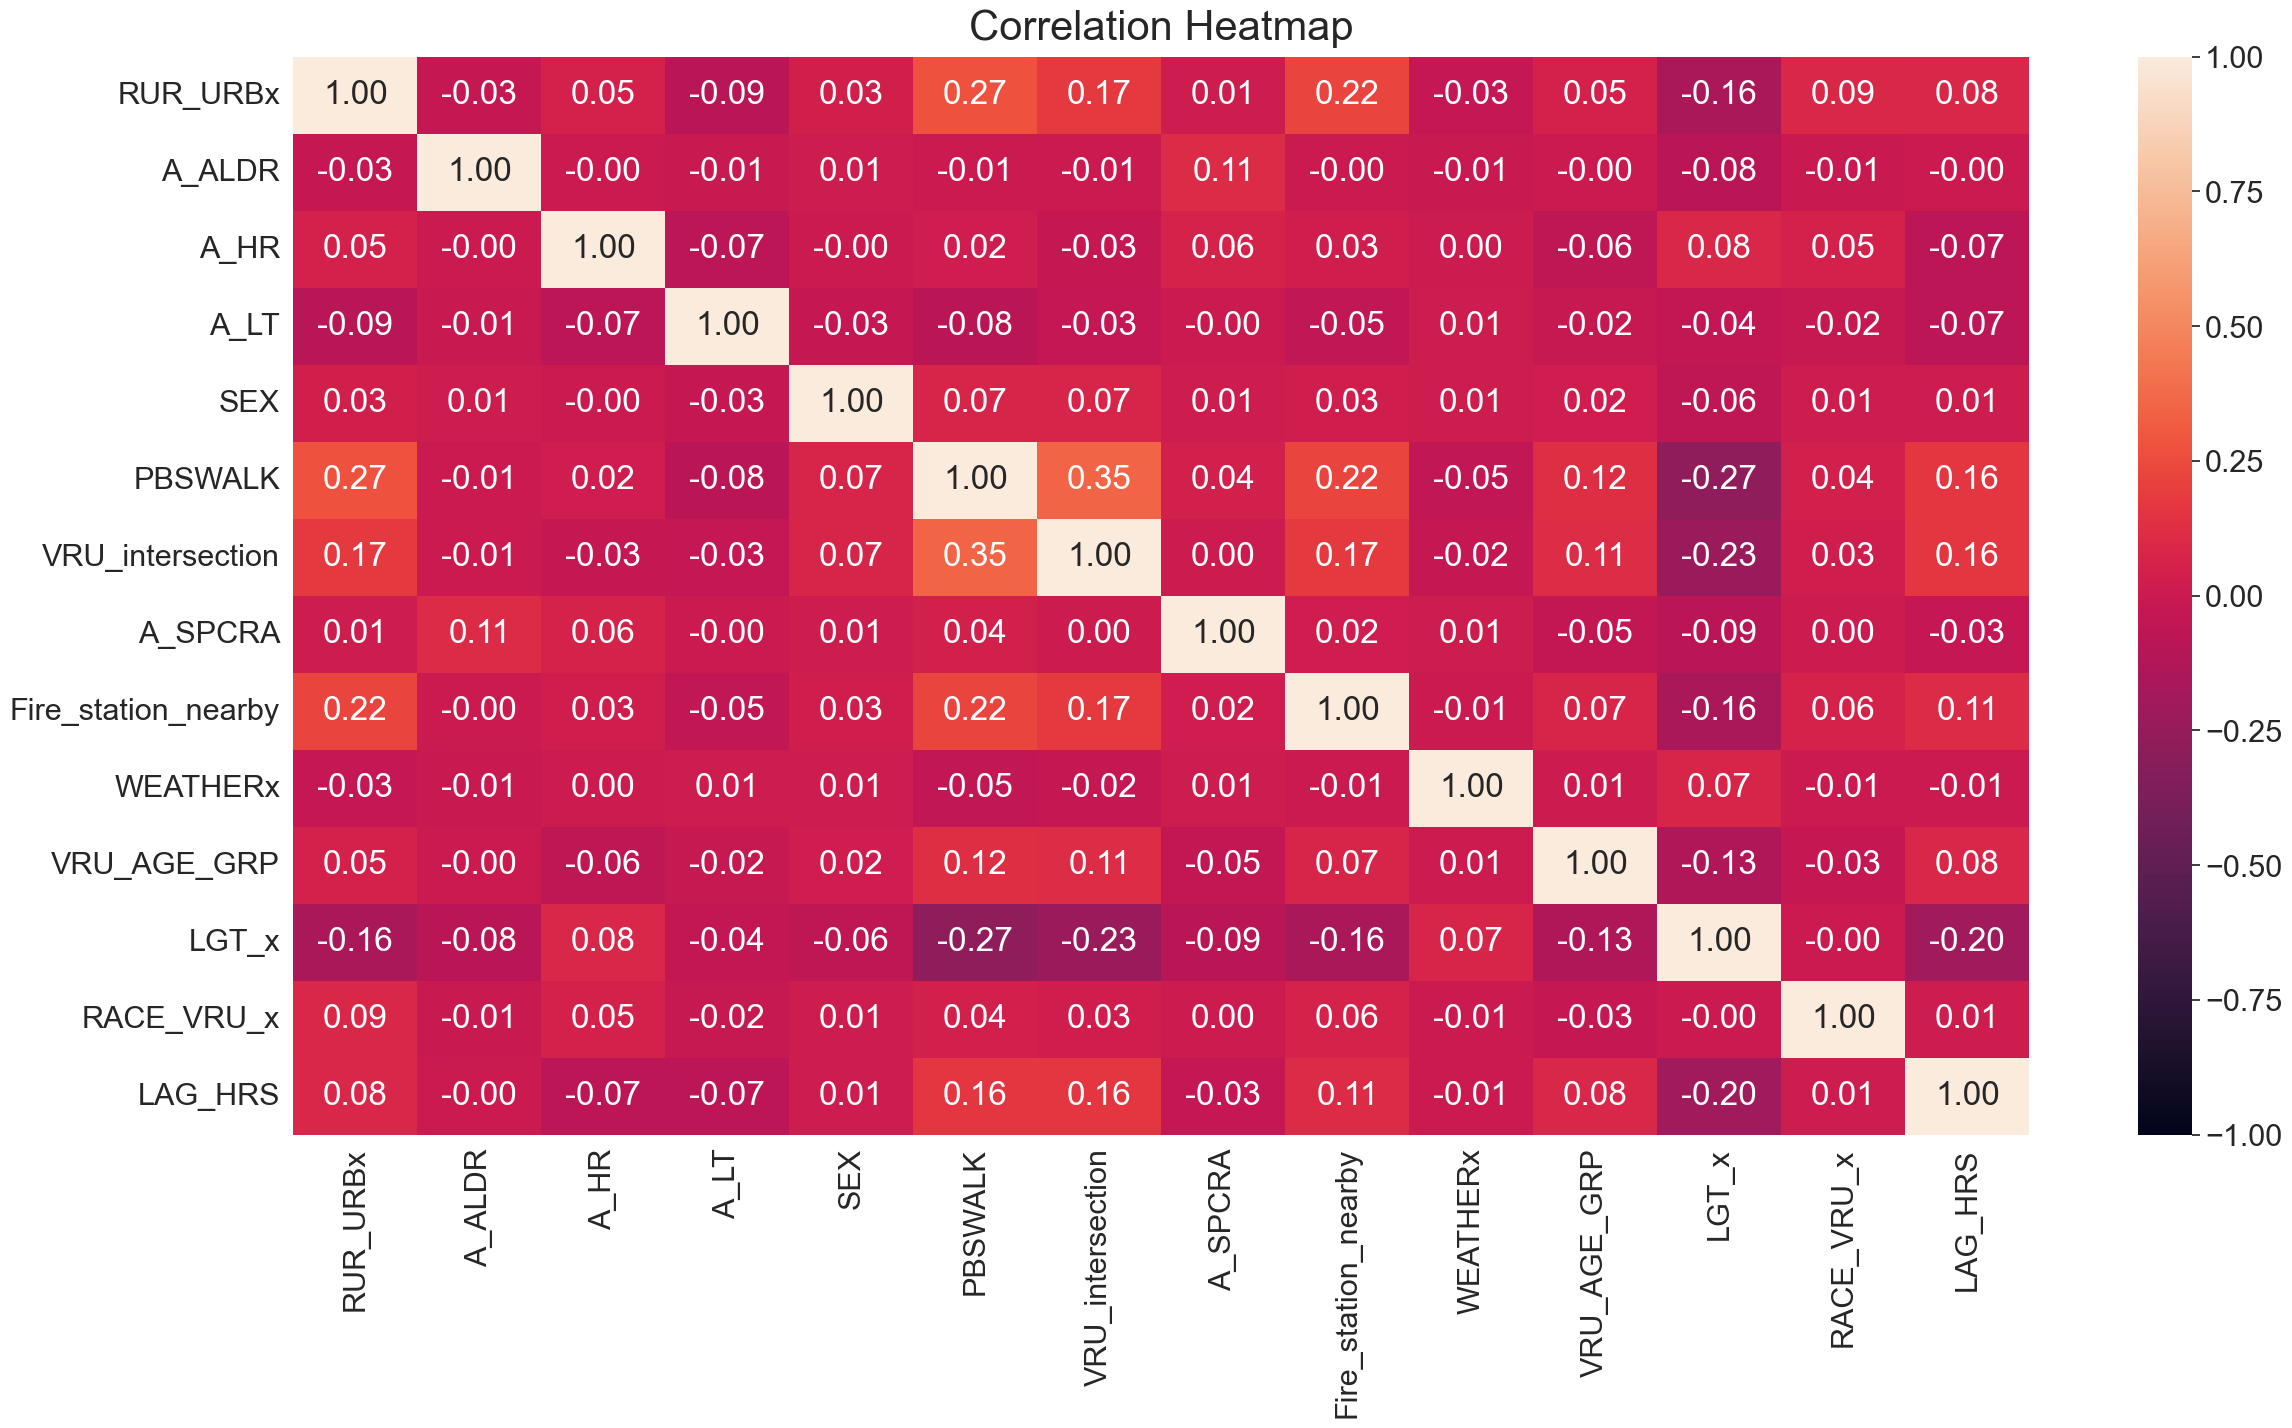

In [341]:
# Heatmap:
df4 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']]
# Correlation Heatmap
# Increase the size of the heatmap.
plt.figure(figsize=(28, 14))
sns.set(font_scale = 2)
# Store heatmap object in a variable to easily access it when you want to include more features (such as title).
# Set the range of values to be displayed on the colormap from -1 to 1, and set the annotation to True to display the correlation values on the heatmap.
heatmap = sns.heatmap(df4.corr(method="spearman"), 
                      vmin=-1, vmax=1, annot=True, fmt='.2f',
                     )  # annot_kws={"size": 20}

# Give a title to the heatmap. Pad defines the distance of the title from the top of the heatmap.
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':30}, pad=12);
#plt.tick_params(axis='both', which='major', labelsize=20)

#plt.savefig("correlation heatmap_reduced.png", pad_inches=0)
plt.show()

## XGBoost regression

In [39]:
# Use GridsearchCV

estimator = xgb.XGBRegressor(subsample=0.7, colsample_bytree=0.8, eta = 0.1)
param_grid = {
            "n_estimators"      : [1000,2000],
            "max_depth" : [5,7],
}


modelCV = GridSearchCV(estimator, param_grid, cv=3,scoring='neg_mean_squared_error')
modelCV.fit(train_X, train_y)
pd.DataFrame(modelCV.cv_results_)

# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error'

# at the dataframe, -ve MSE = mean_test_score
# We take the sqrt of MSE to get RMSE

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,13.578374,2.576209,0.113303,0.023488,5,1000,"{'max_depth': 5, 'n_estimators': 1000}",-6982.433663,-7085.865854,-7057.708729,-7042.002749,43.662057,1
1,19.818836,0.485455,0.161427,0.012789,5,2000,"{'max_depth': 5, 'n_estimators': 2000}",-7196.840265,-7301.794056,-7240.117696,-7246.250672,43.066109,2
2,21.192466,0.302432,0.170785,0.014676,7,1000,"{'max_depth': 7, 'n_estimators': 1000}",-7728.295711,-7718.793630,-7620.311368,-7689.133570,48.819012,3
3,51.830747,12.652470,0.344917,0.088009,7,2000,"{'max_depth': 7, 'n_estimators': 2000}",-8130.119224,-8082.143381,-7965.455826,-8059.239477,69.146946,4


In [40]:
pd.DataFrame(modelCV.cv_results_).to_csv("Model Results_XGBregr.csv", index = False)
print(modelCV.best_score_)
print(modelCV.best_params_)
print(modelCV.scorer_)

-7042.002748782533
{'max_depth': 5, 'n_estimators': 1000}
make_scorer(mean_squared_error, greater_is_better=False)


In [41]:
#Run the best model and get a metric score

start_time = time.time()
start_time2= time.process_time()

xgbregr = xgb.XGBRegressor(n_estimators=1000, max_depth=5, eta=0.1, subsample=0.7, colsample_bytree=0.8)
xgbregr.fit(train_X, train_y)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 13.198013544082642 s
CPU execution time= 44.359375 s


In [40]:
# Evaluation metrics:
# Source: https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide
'''
We have 4 evaluation metrics for regression problems:
Mean Absolute Error (MAE)
Mean Squared Error (MSE)
Root Mean Squared Error (RMSE)
r2 (R-squared)
'''

'\nWe have 4 evaluation metrics for regression problems:\nMean Absolute Error (MAE)\nMean Squared Error (MSE)\nRoot Mean Squared Error (RMSE)\nr2 (R-squared)\n'

In [42]:
# Evaluation metrics:

# Predict the model
pred_y = xgbregr.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  81.734013
MAE :  40.640108
r2 :  0.002268


In [13]:
# Shap value
import shap

In [307]:
df.columns

Index(['Index', 'Year_STCASE', 'YEAR', 'ST_CASE', 'VEH_NO', 'PER_NO',
       'LATITUDE', 'LONGITUDE', 'RUR_URBx', 'WEATHERx', 'Age_grp_driver',
       'A_ALDR', 'A_HR', 'A_LT', 'VRU_AGE_GRP', 'SEX', 'PBCWALK', 'PBSWALK',
       'VRU_intersection', 'LGT_x', 'A_SPCRA', 'RACE_VRU_x', 'Hospital_nearby',
       'Fire_station_nearby', 'VRU_AL', 'LAG_HRS', 'LAG_HRS_y',
       'Instant_death'],
      dtype='object')

In [326]:
# For shap, we only use a sample of values as using all values will take too long processing time

'''
df4=df[['RUR_URBx', 'WEATHERx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'VRU_intersection', 'LGT_x', 'A_SPCRA', 
        'RACE_VRU_x', 
       'Fire_station_nearby', 'LAG_HRS']].sample(5000)
'''


df4 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']] #.sample(20000)




df4 = df4[df4['LAG_HRS']>0]

print(df4.shape)

X = df4.iloc[:, :-1].to_numpy()
y = df4.iloc[:, -1].to_numpy()

#Splitting the data
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

# Regression using xgboost
model = xgb.XGBRegressor(n_estimators=1000, max_depth=7, eta=0.1, subsample=0.7, colsample_bytree=0.8)
#cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)
model.fit(train_X, train_y)


# Predict the model
pred = model.predict(test_X)
  
# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

(10827, 14)
RMSE :  145.103627


In [327]:
# Evaluation metrics:
# Source: https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide
'''
We have 4 evaluation metrics for regression problems:
Mean Absolute Error (MAE)
Mean Squared Error (MSE)
Root Mean Squared Error (RMSE)
r2 (R-squared)
'''

'\nWe have 4 evaluation metrics for regression problems:\nMean Absolute Error (MAE)\nMean Squared Error (MSE)\nRoot Mean Squared Error (RMSE)\nr2 (R-squared)\n'

In [328]:
# Shap code

start_time = time.time()
start_time2= time.process_time()

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(train_X)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


Wall time= 179.71020030975342 s
CPU execution time= 579.84375 s


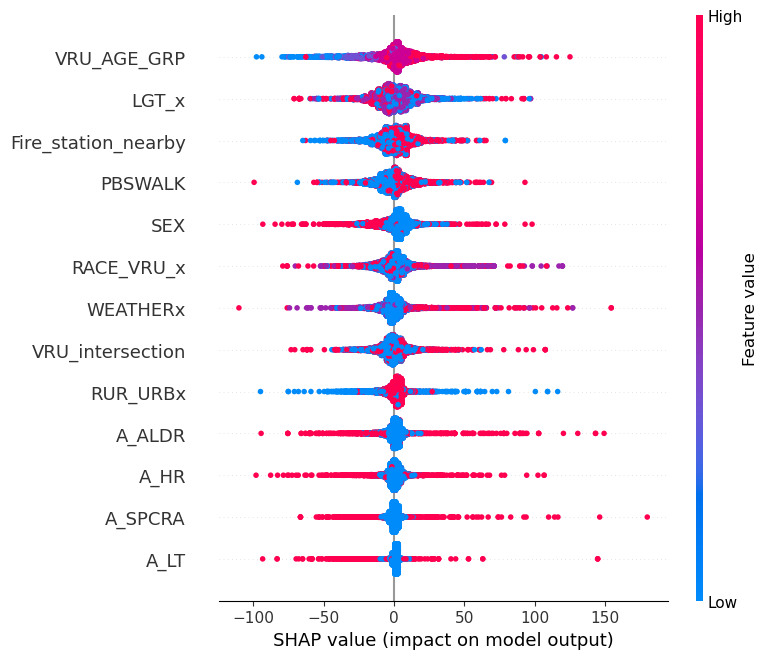

In [329]:
shap.summary_plot(shap_values, features=train_X, feature_names=df4.columns)

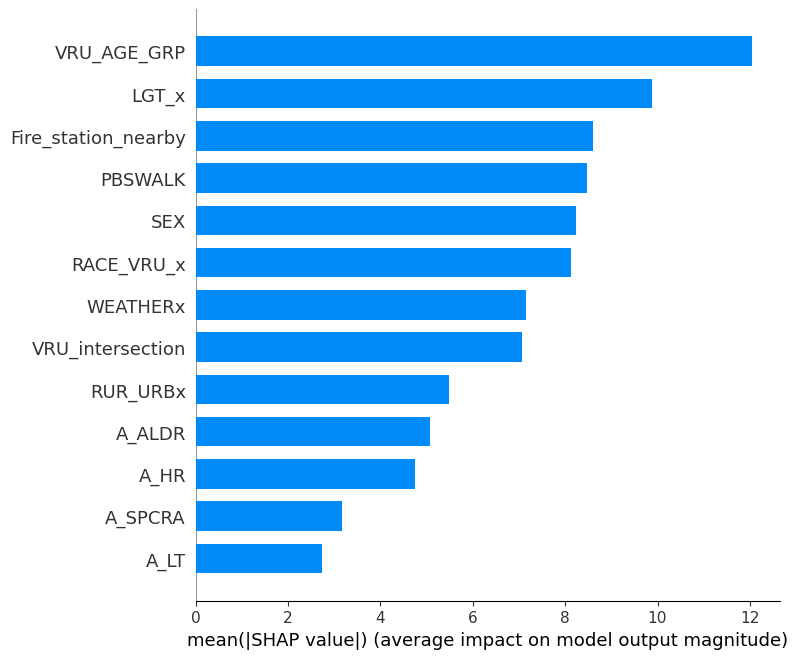

In [330]:
shap.summary_plot(shap_values, train_X, plot_type='bar',feature_names=df4.columns)

## Linear regression

In [4]:
from sklearn import linear_model

In [50]:
start_time = time.time()
start_time2= time.process_time()

regr=linear_model.LinearRegression()
regr.fit(train_X, train_y) 

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 0.01804804801940918 s
CPU execution time= 0.015625 s


In [51]:
# Evaluation metrics:

# Predict the model
pred_y = regr.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  80.624758
MAE :  39.679766
r2 :  0.029165


## DecisionTreeRegressor

In [28]:
from sklearn.tree import DecisionTreeRegressor
#from sklearn.tree import ExtraTreeRegressor  # Don't use this as it should be only used within an ensemble method
from sklearn.ensemble import ExtraTreesRegressor 

In [56]:
start_time = time.time()
start_time2= time.process_time()

dtregr = DecisionTreeRegressor()
dtregr.fit(train_X, train_y) 

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 0.06016349792480469 s
CPU execution time= 0.0625 s


In [57]:
# Evaluation metrics:

# Predict the model
pred_y = dtregr.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  89.460361
MAE :  40.528320
r2 : -0.195280


## ExtraTreesRegressor

In [31]:
# Use GridsearchCV
# We do not need CV for random forests
# In random forests, there is no need for cross-validation or a separate test set to get an unbiased estimate of the test set error. 
# It is estimated internally, during the run
# Source: https://link.springer.com/content/pdf/10.1023/A:1010933404324.pdf

estimator = ExtraTreesRegressor()
param_grid = {
            "n_estimators"      : [1000,2000],
            "bootstrap"      : [True, False],
            "min_samples_split" : [2,4],
}

modelCV = GridSearchCV(estimator, param_grid, cv=3,scoring='neg_mean_squared_error')
modelCV.fit(train_X, train_y)
pd.DataFrame(modelCV.cv_results_)

# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error'

# at the dataframe, -ve MSE = mean_test_score
# We take the sqrt of MSE to get RMSE

KeyboardInterrupt: 

In [32]:
start_time = time.time()
start_time2= time.process_time()

etregr = ExtraTreesRegressor()
etregr.fit(train_X, train_y) 

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 5.52712607383728 s
CPU execution time= 4.734375 s


In [33]:
# Evaluation metrics:

# Predict the model
pred_y = etregr.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  87.435749
MAE :  40.214087
r2 : -0.141791


## RandomForestRegressor

In [6]:
from sklearn.ensemble import RandomForestRegressor

In [10]:
# Use GridsearchCV

estimator = RandomForestRegressor(criterion='squared_error', random_state=1, n_jobs=-1)
param_grid = {
            "n_estimators"      : [1000,2000],
            "max_features"      : ["sqrt", "log2"],
            "min_samples_split" : [2,4],
}

modelCV = GridSearchCV(estimator, param_grid, cv=3,scoring='neg_mean_squared_error')
modelCV.fit(train_X, train_y)
pd.DataFrame(modelCV.cv_results_)

# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error'

# at the dataframe, -ve MSE = mean_test_score
# We take the sqrt of MSE to get RMSE

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,param_min_samples_split,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,9.189565,1.628838,0.609955,0.024483,sqrt,2,1000,"{'max_features': 'sqrt', 'min_samples_split': ...",-7294.084182,-7359.677369,-7267.286585,-7307.016045,38.810987,5
1,18.438284,0.261251,1.878812,0.273772,sqrt,2,2000,"{'max_features': 'sqrt', 'min_samples_split': ...",-7288.730128,-7363.159939,-7269.793610,-7307.227892,40.298414,7
2,8.892607,0.471701,0.888650,0.058664,sqrt,4,1000,"{'max_features': 'sqrt', 'min_samples_split': ...",-7045.646312,-7167.388771,-7092.184126,-7101.739736,50.158342,1
3,17.336917,1.701455,2.117041,0.171469,sqrt,4,2000,"{'max_features': 'sqrt', 'min_samples_split': ...",-7040.075435,-7171.669342,-7095.292803,-7102.345860,53.953983,3
4,8.045555,0.431435,1.400230,0.273457,log2,2,1000,"{'max_features': 'log2', 'min_samples_split': ...",-7294.084182,-7359.677369,-7267.286585,-7307.016045,38.810987,5
5,17.527592,2.682827,3.163639,0.384814,log2,2,2000,"{'max_features': 'log2', 'min_samples_split': ...",-7288.730128,-7363.159939,-7269.793610,-7307.227892,40.298414,7
6,8.522735,0.178417,1.436629,0.078685,log2,4,1000,"{'max_features': 'log2', 'min_samples_split': ...",-7045.646312,-7167.388771,-7092.184126,-7101.739736,50.158342,1
7,19.316166,1.073905,3.734132,0.332317,log2,4,2000,"{'max_features': 'log2', 'min_samples_split': ...",-7040.075435,-7171.669342,-7095.292803,-7102.345860,53.953983,3


In [11]:
pd.DataFrame(modelCV.cv_results_).to_csv("Model Results_RFRegr.csv", index = False)

In [12]:
print(modelCV.best_score_)
print(modelCV.best_params_)
print(modelCV.scorer_)

-7101.739736229286
{'max_features': 'sqrt', 'min_samples_split': 4, 'n_estimators': 1000}
make_scorer(mean_squared_error, greater_is_better=False)


In [18]:
#Run the best model and get a metric score

start_time = time.time()
start_time2= time.process_time()

forest = RandomForestRegressor(n_estimators=1000, criterion='squared_error',
                               max_features = 'sqrt', min_samples_split = 4,
                               random_state=1, n_jobs=-1)
forest.fit(train_X, train_y) 
#y_train_pred = forest.predict(X_train)
#y_test_pred = forest.predict(X_test)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 24.15188479423523 s
CPU execution time= 45.84375 s


In [17]:
# Evaluation metrics:

# Predict the model
pred_y = forest.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  83.396587
MAE :  39.572724
r2 : -0.038736


## RANdom SAmple Consensus (RANSAC) algorithm

In [7]:
from sklearn.linear_model import RANSACRegressor
#Source: https://github.com/BioWar/Python-Machine-Learning/blob/master/Predicting%20Continuous%20Target%20Variables%20with%20Regression%20Analysis.ipynb

In [9]:
# Use GridsearchCV

estimator = RANSACRegressor(linear_model.LinearRegression(), random_state=0)
param_grid = {
    "max_trials": [50, 100],
    "min_samples": [50, 100, 150, 200],
    "residual_threshold": [5, 10, 15, 20, 30],
}

modelCV = GridSearchCV(estimator, param_grid, cv=3,scoring='neg_mean_squared_error')
modelCV.fit(train_X, train_y)
pd.DataFrame(modelCV.cv_results_)

# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error'

# at the dataframe, -ve MSE = mean_test_score
# We take the sqrt of MSE to get RMSE

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_trials,param_min_samples,param_residual_threshold,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.579272,0.649290,0.000334,4.727191e-04,50,50,5,"{'max_trials': 50, 'min_samples': 50, 'residua...",-7208.051655,-7358.770255,-7337.534212,-7301.452041,66.610642,31
1,0.122533,0.005980,0.000668,4.724944e-04,50,50,10,"{'max_trials': 50, 'min_samples': 50, 'residua...",-7238.735147,-7394.837856,-7379.584470,-7337.719157,70.268733,37
2,0.135910,0.017638,0.001180,1.028774e-03,50,50,15,"{'max_trials': 50, 'min_samples': 50, 'residua...",-7234.621246,-7397.399703,-7387.022236,-7339.681062,74.409213,39
3,0.124830,0.009497,0.000679,4.802568e-04,50,50,20,"{'max_trials': 50, 'min_samples': 50, 'residua...",-7220.859696,-7390.839043,-7383.950183,-7331.882974,78.555671,35
4,0.131810,0.006548,0.000335,4.730562e-04,50,50,30,"{'max_trials': 50, 'min_samples': 50, 'residua...",-7194.972789,-7365.618983,-7357.841424,-7306.144399,78.674298,33
5,0.129102,0.009920,0.000334,4.728314e-04,50,100,5,"{'max_trials': 50, 'min_samples': 100, 'residu...",-7088.326502,-7554.318199,-7210.650121,-7284.431607,197.264368,25
6,0.127599,0.006053,0.000669,4.728877e-04,50,100,10,"{'max_trials': 50, 'min_samples': 100, 'residu...",-7163.580173,-7266.513364,-7307.190208,-7245.761248,60.437010,19
7,0.141064,0.000620,0.000000,0.000000e+00,50,100,15,"{'max_trials': 50, 'min_samples': 100, 'residu...",-7198.008265,-7308.865926,-7359.140506,-7288.671566,67.313985,26
8,0.134750,0.006935,0.005218,7.378733e-03,50,100,20,"{'max_trials': 50, 'min_samples': 100, 'residu...",-7200.584811,-7330.609590,-7369.555410,-7300.249937,72.245171,29
9,0.156475,0.012507,0.000000,0.000000e+00,50,100,30,"{'max_trials': 50, 'min_samples': 100, 'residu...",-7186.402626,-7336.689851,-7352.021175,-7291.704551,74.722303,27


In [10]:
pd.DataFrame(modelCV.cv_results_).to_csv("Model Results_RANSAC.csv", index = False)

In [11]:
print(modelCV.best_score_)
print(modelCV.best_params_)
print(modelCV.scorer_)   

-6884.736861508503
{'max_trials': 50, 'min_samples': 150, 'residual_threshold': 5}
make_scorer(mean_squared_error, greater_is_better=False)


In [13]:
#Run the best model and get a metric score

start_time = time.time()
start_time2= time.process_time()

ransac = RANSACRegressor(linear_model.LinearRegression(),
                        max_trials=50,
                        min_samples=150,
                        residual_threshold=5.0,
                        random_state=0)
ransac.fit(train_X, train_y)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 0.20315003395080566 s
CPU execution time= 0.375 s


In [14]:
# Evaluation metrics:

# Predict the model
pred_y = ransac.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  82.557212
MAE :  34.202367
r2 : -0.017931


In [ ]:
# For ANN, 
# see https://www.analyticsvidhya.com/blog/2021/08/a-walk-through-of-regression-analysis-using-artificial-neural-networks-in-tensorflow/

## ANN from sklearn

In [6]:
from sklearn.neural_network import MLPRegressor

from sklearn.metrics import get_scorer_names
get_scorer_names()

In [ ]:
#Test different model
# Use GridsearchCV

estimator = MLPRegressor(max_iter=400, random_state=1)
param_grid = {
    "learning_rate_init": [0.01, 0.001],
    "activation": ["relu", "tanh"],
    "solver": ["sgd", "adam"]
}

modelCV = GridSearchCV(estimator, param_grid, cv=3,scoring='neg_mean_squared_error')
modelCV.fit(train_X, train_y)
pd.DataFrame(modelCV.cv_results_)

# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error'

# at the dataframe, -ve MSE = mean_test_score
# We take the sqrt of MSE to get RMSE


C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\User\anaconda3\envs

In [28]:
pd.DataFrame(modelCV.cv_results_).to_csv("Model Results_MLP.csv", index = False)

In [25]:
print(modelCV.best_score_)
print(modelCV.best_params_)
print(modelCV.scorer_)   
# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error' in the previous code

-6606.74829883386
{'activation': 'tanh', 'learning_rate_init': 0.001, 'solver': 'adam'}
make_scorer(mean_squared_error, greater_is_better=False)


In [26]:
#Run the best model and get a metric score
start_time = time.time()
start_time2= time.process_time()

ANNregr = MLPRegressor(max_iter=2000, random_state=1,
                    activation="tanh", learning_rate_init=0.001, solver= 'adam' )
ANNregr.fit(train_X, train_y)
ANNregr.score(test_X, test_y)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 326.6253824234009 s
CPU execution time= 321.28125 s


In [12]:
# Evaluation metrics:

# Predict the model
pred_y = ANNregr.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

RMSE :  82.183846
MAE :  40.626378
r2 : -0.008745


## Random Survival Forest from sksurv

In [148]:
from sksurv.ensemble import RandomSurvivalForest
# Source:https://scikit-survival.readthedocs.io/en/stable/api/index.html

In [238]:
df5 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']]   # .sample(5000)  # sample for shap


print(df5.shape)
'''
df4['status'] = 1
df4.loc[df4['LAG_HRS']==720,'status'] = 0
df4 = df4[df4['LAG_HRS']>0]
'''
df5.columns

(33615, 14)


Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x', 'LAG_HRS'],
      dtype='object')

In [239]:
df5['event'] = 1
df5.loc[df5['LAG_HRS']==720, 'event'] = 0


train, validate, test = np.split(df5.sample(frac=1), [int(.6*len(df5)), int(.8*len(df5))])

# In survival analysis, "event/ status" ==1 means that time is not censored. 
# In survival analysis, "event/ status" ==0 means that time is censored. So, it does not represent the true death time.
# Source for event value: https://www.youtube.com/watch?v=Wo9RNcHM_bs



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [240]:
# Data preparation

x_train = train.drop(columns=['LAG_HRS', 'event'])
y_train = train['LAG_HRS']
e_train = train['event']
ye_train = train[['LAG_HRS', 'event']]

x_test = test.drop(columns=['LAG_HRS', 'event'])
y_test = test['LAG_HRS']
e_test = test['event']
ye_test = test[['LAG_HRS', 'event']]

x_val = validate.drop(columns=['LAG_HRS', 'event'])
y_val = validate['LAG_HRS']
e_val = validate['event']
ye_val = validate[['LAG_HRS', 'event']]

dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape)

(20169,)


In [152]:
# Train Survival Model (Random Survival Forest)


# Count the time for modelling
start_time = time.time()
start_time2= time.process_time()

# train RSF
rsf = RandomSurvivalForest(n_estimators=50,
                           min_samples_split=20,
                           min_samples_leaf=10,
                           max_features="sqrt",
                           oob_score=True,
                           n_jobs=-1,
                           random_state=20)
rsf.fit(x_train, y_train_surv)


end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")


# Ignore the rest of code
'''
cindex_train = rsf.score(x_train, y_train_surv)
cindex_oob = rsf.oob_score_
cindex_val = rsf.score(x_val, y_val_surv)
cindex_test = rsf.score(x_test, y_test_surv)

print('Train cindex {:.2f}'.format(cindex_train*100))
print('Val cindex {:.2f}'.format(cindex_val*100))
print('Test cindex {:.2f}'.format(cindex_test*100))
print('oob cindex {:.2f}'.format(cindex_oob*100))
'''




Wall time= 7.80482816696167 s
CPU execution time= 11.109375 s


"\ncindex_train = rsf.score(x_train, y_train_surv)\ncindex_oob = rsf.oob_score_\ncindex_val = rsf.score(x_val, y_val_surv)\ncindex_test = rsf.score(x_test, y_test_surv)\n\nprint('Train cindex {:.2f}'.format(cindex_train*100))\nprint('Val cindex {:.2f}'.format(cindex_val*100))\nprint('Test cindex {:.2f}'.format(cindex_test*100))\nprint('oob cindex {:.2f}'.format(cindex_oob*100))\n"

In [153]:
# Prepare the Data and the Survival Curves for SurvSHAP

surv_train = rsf.predict_survival_function(x_train, return_array=True)
surv_val = rsf.predict_survival_function(x_val, return_array=True)
surv_test = rsf.predict_survival_function(x_test, return_array=True)

event_times=rsf.event_times_

#Prepare Data for Explanation
xte_data = (x_train, y_train, e_train,
            x_val, y_val, e_val,
            x_test, y_test, e_test)

#Prepare the Survival Curves for Explanation
survival_curves = (surv_train, surv_val, surv_test)

In [154]:
# Evaluation metrics:

# Predict the model
pred_y = rsf.predict(x_test)


# RMSE Computation
rmse = np.sqrt(np.sqrt(MSE(y_test, pred_y)))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = np.sqrt(MAE(y_test, pred_y))
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(y_test, pred_y)
print("r2 : % f" %(r_squared_score))

print(rsf.score(x_test, y_test_surv))


# concordance index
cindex_test = cgbsa_model.score(x_test, y_test_surv)
print('Test cindex {:.2f}'.format(cindex_test*100))

RMSE :  39.361640
MAE :  39.204300
r2 : -385.773943
0.5490418875912855


## ComponentwiseGradientBoostingSurvivalAnalysis from sksurv

In [147]:
from sksurv.ensemble import ComponentwiseGradientBoostingSurvivalAnalysis

In [223]:
# Data preparation
df5 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']].sample(10000)   # .sample(5000)  # sample for shap

df5_700 = df[df['LAG_HRS']>700][['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
                                          'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
                                          'Fire_station_nearby', 
                                          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
                                          'LAG_HRS']]

df5 = pd.concat([df5, df5_700])


print(df5.shape)
df5.columns

df5['event'] = 1
df5.loc[df5['LAG_HRS']==720, 'event'] = 0




(10020, 14)


In [225]:
# Data preparation
train, validate, test = np.split(df5.sample(frac=1), [int(.6*len(df5)), int(.8*len(df5))])

x_train = train.drop(columns=['LAG_HRS', 'event'])
y_train = train['LAG_HRS']
e_train = train['event']
ye_train = train[['LAG_HRS', 'event']]

x_test = test.drop(columns=['LAG_HRS', 'event'])
y_test = test['LAG_HRS']
e_test = test['event']
ye_test = test[['LAG_HRS', 'event']]

x_val = validate.drop(columns=['LAG_HRS', 'event'])
y_val = validate['LAG_HRS']
e_val = validate['event']
ye_val = validate[['LAG_HRS', 'event']]

dt = np.dtype('bool,float')
y_train_surv = np.array([(bool(e), y) for e, y in zip(e_train, y_train)], dtype=dt)
y_val_surv = np.array([(bool(e), y) for e, y in zip(e_val, y_val)], dtype=dt)
y_test_surv = np.array([(bool(e), y) for e, y in zip(e_test, y_test)], dtype=dt)
print(y_train_surv.shape)

(6012,)


In [226]:
# train model

start_time = time.time()
start_time2= time.process_time()

cgbsa_model = ComponentwiseGradientBoostingSurvivalAnalysis()
cgbsa_model.fit(x_train, y_train_surv)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")


Wall time= 64.89643931388855 s
CPU execution time= 63.296875 s


In [227]:
# Evaluation metrics:

# Predict the model
pred_y = cgbsa_model.predict(x_test)


# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(y_test, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(y_test, pred_y)
print("r2 : % f" %(r_squared_score))

# concordance index
cindex_test = cgbsa_model.score(x_test, y_test_surv)
print('Test cindex {:.2f}'.format(cindex_test*100))

RMSE :  90.499917
MAE :  27.073104
r2 : -0.097718
Test cindex 63.62


In [202]:
'''
y_test.describe()

print(min(pred_y))
print(max(pred_y))
print(np.mean(pred_y))

pred_yy = (pred_y-min(pred_y))*(720-0)/(max(pred_y) -min(pred_y) )
print(min(pred_yy))
print(max(pred_yy))
print(np.mean(pred_yy))
'''

-0.2594512533714655
0.33536684288159696
0.02505965061304482


## GradientBoostingSurvivalAnalysis from sksurv

In [217]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis

In [218]:
# train model

start_time = time.time()
start_time2= time.process_time()

gbsa_model = GradientBoostingSurvivalAnalysis()
gbsa_model.fit(x_train, y_train_surv)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 70.40931463241577 s
CPU execution time= 69.234375 s


In [220]:
# Evaluation metrics:

# Predict the model
pred_y = gbsa_model.predict(x_test)


# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(y_test, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(y_test, pred_y)
print("r2 : % f" %(r_squared_score))

# concordance index
cindex_test = gbsa_model.score(x_test, y_test_surv)
print('Test cindex {:.2f}'.format(cindex_test*100))

RMSE :  86.147820
MAE :  24.140262
r2 : -0.085296


In [222]:
'''
# Corcordance index
The concordance index is defined as the proportion of all comparable pairs in which the predictions and outcomes are concordant.

Two samples are comparable if (i) both of them experienced an event (at different times), or (ii) the one with a shorter observed survival time experienced an event, in which case the event-free subject “outlived” the other. A pair is not comparable if they experienced events at the same time.

Concordance intuitively means that two samples were ordered correctly by the model. More specifically, two samples are concordant, if the one with a higher estimated risk score has a shorter actual survival time. When predicted risks are identical for a pair, 0.5 rather than 1 is added to the count of concordant pairs.

Source: https://scikit-survival.readthedocs.io/en/stable/api/generated/sksurv.metrics.concordance_index_censored.html


The most frequently used evaluation metric of survival models is the concordance index (c index, c statistic). It is a measure of rank correlation between predicted risk scores 
 and observed time points that is closely related to Kendall’s τ. It is defined as the ratio of correctly ordered (concordant) pairs to comparable pairs. Two samples 
 and  are comparable if the sample with lower observed time  experienced an event, i.e., if 
 and , where
 is a binary event indicator. A comparable pair 
 is concordant if the estimated risk 
 by a survival model is higher for subjects with lower survival time, i.e., 
, otherwise the pair is discordant. 

Source: https://scikit-survival.readthedocs.io/en/stable/user_guide/evaluating-survival-models.html#

'''

'\n# Corcordance index\nThe concordance index is defined as the proportion of all comparable pairs in which the predictions and outcomes are concordant.\n\nTwo samples are comparable if (i) both of them experienced an event (at different times), or (ii) the one with a shorter observed survival time experienced an event, in which case the event-free subject “outlived” the other. A pair is not comparable if they experienced events at the same time.\n\nConcordance intuitively means that two samples were ordered correctly by the model. More specifically, two samples are concordant, if the one with a higher estimated risk score has a shorter actual survival time. When predicted risks are identical for a pair, 0.5 rather than 1 is added to the count of concordant pairs.\n\n\n'

## ExtraSurvivalTrees from sksurv

In [228]:
from sksurv.ensemble import ExtraSurvivalTrees

In [234]:
# train model

start_time = time.time()
start_time2= time.process_time()

est_model = ExtraSurvivalTrees()
est_model.fit(x_train, y_train_surv)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 3.484563112258911 s
CPU execution time= 3.484375 s


In [235]:
# Evaluation metrics:

# Predict the model
pred_y = est_model.predict(x_test)


# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(y_test, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(y_test, pred_y)
print("r2 : % f" %(r_squared_score))

# concordance index
cindex_test = gbsa_model.score(x_test, y_test_surv)
print('Test cindex {:.2f}'.format(cindex_test*100))

RMSE :  732.159907
MAE :  718.675271
r2 : -70.846629
Test cindex 63.25


## SurvivalTree from sksurve

In [237]:
from sksurv.tree import SurvivalTree

In [248]:
get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_negative_likelihood_ratio',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'positive_likelihood_ratio',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',

In [249]:
# Use GridsearchCV

estimator = SurvivalTree()  
param_grid = {
    "max_depth": [5, 7],
    "min_samples_split": [6,10],
}

modelCV = GridSearchCV(estimator, param_grid, cv=3,scoring='neg_negative_likelihood_ratio')
modelCV.fit(x_train, y_train_surv)
pd.DataFrame(modelCV.cv_results_)

# Gridsearch CV usually optimizes based on the maximum value of evaluation metric
# so that's why we chose scoring='neg_mean_squared_error'

# at the dataframe, -ve MSE = mean_test_score
# We take the sqrt of MSE to get RMSE

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_scorer.py", line 742, in negative_likelihood_ratio
    return class_likelihood_ratios(y_true, y_pred)[1]
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_classification.py", line 1765, in class_likelihood_ratios
    y_type, y_true, y_pred = _check_targets(y_t

Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\model_selection\_validation.py", line 767, in _score
    scores = scorer(estimator, X_test, y_test)
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_scorer.py", line 234, in __call__
    return self._score(
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_scorer.py", line 282, in _score
    return self._sign * self._score_func(y_true, y_pred, **self._kwargs)
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_scorer.py", line 742, in negative_likelihood_ratio
    return class_likelihood_ratios(y_true, y_pred)[1]
  File "C:\Users\User\anaconda3\envs\myenv2\lib\site-packages\sklearn\metrics\_classification.py", line 1765, in class_likelihood_ratios
    y_type, y_true, y_pred = _check_targets(y_t

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,0.105613,0.003692,0.084559,0.050102,5,6,"{'max_depth': 5, 'min_samples_split': 6}",NaN,NaN,NaN,NaN,NaN,1
1,0.098594,0.004935,0.048798,0.001252,5,10,"{'max_depth': 5, 'min_samples_split': 10}",NaN,NaN,NaN,NaN,NaN,1
2,0.141522,0.011598,0.053976,0.006903,7,6,"{'max_depth': 7, 'min_samples_split': 6}",NaN,NaN,NaN,NaN,NaN,1
3,0.125667,0.003783,0.044452,0.002061,7,10,"{'max_depth': 7, 'min_samples_split': 10}",NaN,NaN,NaN,NaN,NaN,1


In [260]:
# train model

start_time = time.time()
start_time2= time.process_time()

param_grid = {
    "max_depth": [5, 7],
    "min_samples_split": [7,10],
}

survtree_model = SurvivalTree(max_depth = 5,min_samples_split = 10 )
survtree_model.fit(x_train, y_train_surv)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 0.1353623867034912 s
CPU execution time= 0.125 s


In [261]:
# Evaluation metrics:

# Predict the model
pred_y = survtree_model.predict(x_test)


# RMSE Computation
rmse = np.sqrt(MSE(y_test, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(y_test, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(y_test, pred_y)
print("r2 : % f" %(r_squared_score))

# concordance index
cindex_test = gbsa_model.score(x_test, y_test_surv)
print('Test cindex {:.2f}'.format(cindex_test*100))

RMSE :  1861.002262
MAE :  1841.235530
r2 : -526.353965
Test cindex 64.03


## XGBoost survival

In [263]:
# survival analysis in xgboost:
# https://xgboost.readthedocs.io/en/stable/python/survival-examples/index.html

# XGboost survival # Dataset preparation
df6 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']] #.sample(2000)  # Use sample for the shap

'''
# Dropping the insignificant variables based on initial survival analysis:
df2 = df2.drop(columns=['Age_grp_driver','A_HR','VRU_AGE_GRP','PBCWALK', 'PBSWALK','Hospital_nearby','VRU_AL'])
'''
df6.columns

# Event column
df6["event"] = 1
df6.loc[df6["LAG_HRS"]==720, "event"] = 0

# Upper and lower bound columns
df6['y_lower_bound'] = 0
df6.loc[df6["event"]==1,'y_lower_bound'] = df6["LAG_HRS"]  # uncensored data
df6.loc[df6["event"]==1,'y_lower_bound'] = df6["LAG_HRS"]  # right censored data

df6['y_upper_bound'] = 0 
df6.loc[df6["event"]==1,'y_upper_bound'] = df6["LAG_HRS"]  # uncensored data
df6.loc[df6["event"]==0,'y_upper_bound'] = +np.inf  # right censored data


df6 = df6[df6['LAG_HRS']>0]


# Event = 0 means censored; event= 1 means uncensored.
# For censored data, we have right censored data
# Right censoring – a data point is above a certain value but it is unknown by how much. 
# Right censoring: These are data for which we know only its minimum value.
# Left censoring - These are data for which we know only its maximum value.


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

In [177]:
df6.columns

Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x', 'LAG_HRS', 'event',
       'y_lower_bound', 'y_upper_bound'],
      dtype='object')

In [191]:
'''
X = df6.iloc[:, :-4].to_numpy()
y = df6['LAG_HRS'].to_numpy()
y_lower = df6['y_lower_bound'].to_numpy()
y_upper = df6['y_upper_bound'].to_numpy()


train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)
'''

In [264]:
X = df6.drop(columns=['LAG_HRS', 'event']).to_numpy()
y = df6['LAG_HRS'].to_numpy()

train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

In [227]:
df6.columns

Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x', 'LAG_HRS', 'event',
       'y_lower_bound', 'y_upper_bound'],
      dtype='object')

In [265]:
y_lower_train = train_X[:, -2]
y_upper_train = train_X[:, -1]

y_lower_test = test_X[:, -2]
y_upper_test = test_X[:, -1]

train_X = train_X[:, :-2]
test_X = test_X[:, :-2]

In [269]:
#check shape
print(train_X.shape)  # should have 13 columns at the end
print(test_X.shape)  # should have 13 columns at the end

(7578, 13)
(3249, 13)


In [230]:
df6.iloc[:, :-4].columns

Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x'],
      dtype='object')

In [267]:
dtrain = xgb.DMatrix(train_X, label_lower_bound=y_lower_train, label_upper_bound=y_upper_train, label=train_y)
dtest = xgb.DMatrix(test_X, label_lower_bound=y_lower_test, label_upper_bound=y_upper_test, label=test_y)

In [268]:
start_time = time.time()
start_time2= time.process_time()

params = {'objective': 'survival:aft', 'eval_metric': 'aft-nloglik',
'aft_loss_distribution': 'logistic',
'aft_loss_distribution_scale': 1.20,'tree_method': 'hist', 'learning_rate': 0.05, 'max_depth': 2}
bst = xgb.train(params, dtrain, num_boost_round=5, evals=[(dtest, 'Test')])    # evals=[(dtrain, 'train')] previously


# aft_loss_distribution = {'extreme', 'logistic', 'normal'}


end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

[0]	Test-aft-nloglik:5.68000
[1]	Test-aft-nloglik:5.56294
[2]	Test-aft-nloglik:5.46512
[3]	Test-aft-nloglik:5.38227
[4]	Test-aft-nloglik:5.31093
Wall time= 0.4572165012359619 s
CPU execution time= 0.140625 s


In [273]:
# Evaluation metrics:

# Predict the model
pred_y = bst.predict(dtest)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

# concordance index
#cindex_test = bst.score(test_X, test_y)
#print('Test cindex {:.2f}'.format(cindex_test*100))


RMSE :  148.899686
MAE :  73.341519
r2 : -0.318874


In [296]:
df_test_pred_y_1 = pd.DataFrame(data = pred_y, columns = ['pred_y'])
df_test_pred_y_2 = pd.DataFrame(data = test_y, columns = ['test_y'])
df_test_pred_y = pd.concat([df_test_pred_y_1,df_test_pred_y_2], axis = 1)
df_test_pred_y.isnull().sum()

pred_y    0
test_y    0
dtype: int64

In [ ]:
'''
from xgbse.metrics import concordance_index
pred_y = bst.predict(dtest)
cind = concordance_index(test_y, -pred_y, risk_strategy="precomputed")
'''

In [61]:
# Shap using Nafis code
import shap


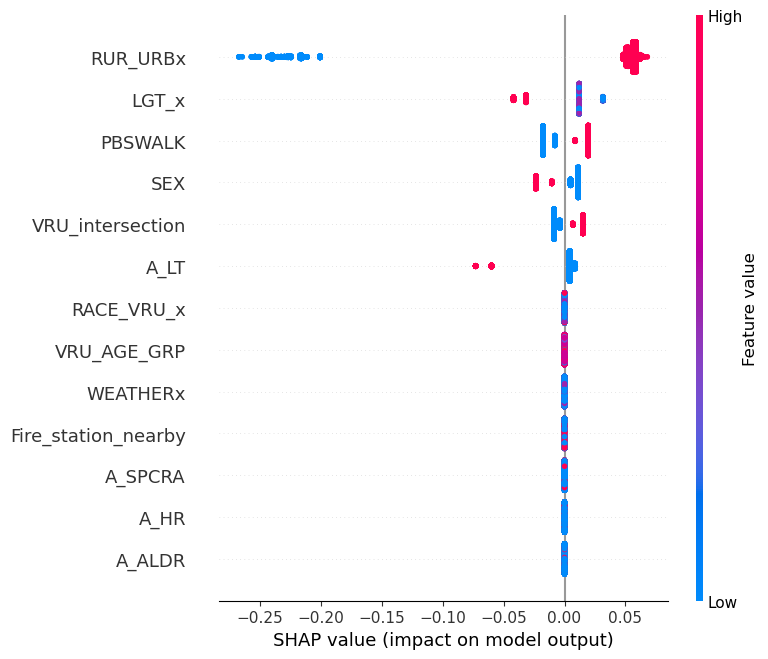

In [298]:
explainer = shap.TreeExplainer(bst)
shap_values = explainer.shap_values(train_X)
shap.summary_plot(shap_values, features=train_X, feature_names=df6.iloc[:, :-4].columns)

## XGBoost survival embeddings

In [115]:
# XGBoost Survival Embeddings
# See https://pypi.org/project/xgbse/
# https://github.com/loft-br/xgboost-survival-embeddings
# https://github.com/loft-br/xgboost-survival-embeddings/blob/main/examples/how_xgbse_works.ipynb
    
from xgbse import XGBSEKaplanNeighbors    # pip install xgbse
from xgbse import XGBSEDebiasedBCE
from xgbse.converters import convert_to_structured

In [101]:
df5 = df[['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
       'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
          'Fire_station_nearby', 
          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
          'LAG_HRS']].sample(4000) # Sample because it is taking long time  

df5_700 = df[df['LAG_HRS']>700][['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX',
                                          'PBSWALK', 'VRU_intersection', 'A_SPCRA', 
                                          'Fire_station_nearby', 
                                          'WEATHERx', 'VRU_AGE_GRP','LGT_x','RACE_VRU_x',
                                          'LAG_HRS']]

df5 = pd.concat([df5, df5_700])

# .sample(5000)  # sample for shap   # Data structure similar to input for random survival forest


print(df5.shape)  # 14 columns , so OK
'''
df4['status'] = 1
df4.loc[df4['LAG_HRS']==720,'status'] = 0
df4 = df4[df4['LAG_HRS']>0]
'''
df5.columns

(4020, 14)


Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x', 'LAG_HRS'],
      dtype='object')

In [102]:
df5.columns

Index(['RUR_URBx', 'A_ALDR', 'A_HR', 'A_LT', 'SEX', 'PBSWALK',
       'VRU_intersection', 'A_SPCRA', 'Fire_station_nearby', 'WEATHERx',
       'VRU_AGE_GRP', 'LGT_x', 'RACE_VRU_x', 'LAG_HRS'],
      dtype='object')

In [103]:
df5['event'] = 1
df5.loc[df5['LAG_HRS']==720, 'event'] = 0

In [104]:
X = df5.drop(['LAG_HRS', 'event'], axis=1)
y = convert_to_structured(df5['LAG_HRS'], df5['event'])

In [105]:
train_X, test_X, train_y, test_y = train_test_split(X, y,
                      test_size = 0.3, random_state = 123)

In [116]:
PARAMS_XGB_AFT = {
    'objective': 'survival:aft',
    'eval_metric': 'aft-nloglik',
    'aft_loss_distribution': 'normal',
    'aft_loss_distribution_scale': 1.0,
    'tree_method': 'hist', 
    'learning_rate': 0.1, 
    'max_depth': 8, 
    'booster':'dart',
    'subsample':0.5,
    'min_child_weight': 50,
    'colsample_bynode':0.5
}   # default was 'learning_rate': 5e-2


PARAMS_LR = {
    'C': 1e-3,
    'max_iter': 500
}


In [107]:
# fitting xgbse model
start_time = time.time()
start_time2= time.process_time()

xgbse_model = XGBSEKaplanNeighbors(PARAMS_XGB_AFT, n_neighbors=10)
xgbse_model.fit(train_X,train_y)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

XGBSEKaplanNeighbors(n_neighbors=10,
                     xgb_params={'aft_loss_distribution': 'normal',
                                 'aft_loss_distribution_scale': 1.0,
                                 'booster': 'dart', 'colsample_bynode': 0.5,
                                 'eval_metric': 'aft-nloglik',
                                 'learning_rate': 0.1, 'max_depth': 8,
                                 'min_child_weight': 50,
                                 'objective': 'survival:aft', 'subsample': 0.5,
                                 'tree_method': 'hist'})

In [119]:
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 110.13452863693237 s
CPU execution time= 268.84375 s


In [108]:
pred_y = xgbse_model.predict(test_X)


In [114]:
pred_y.describe()

,721,720,720,719,719,718,718,717,717,716,716,716
count,1206.0,1206.0,1206.0,1206.0,1206.0,1206.0,1206.0,1206.0,1206.0,1206.000000,1206.000000,1206.000000
mean,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002488,0.002488,0.002488
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.022175,0.022175,0.022175
min,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000
max,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.200000,0.200000,0.200000


In [109]:
# Evaluation metrics:

# Predict the model
pred_y = xgbse_model.predict(test_X)


# RMSE Computation
rmse = np.sqrt(MSE(test_y, pred_y))  # Without sqrt, we get MSE. sqrt gives us RMSE
print("RMSE : % f" %(rmse))

# MAE
mae = MAE(test_y, pred_y)
print("MAE : % f" %(mae))

#r2:
r_squared_score = r2_score(test_y, pred_y)
print("r2 : % f" %(r_squared_score))

ValueError: dtype='numeric' is not compatible with arrays of bytes/strings.Convert your data to numeric values explicitly instead.

In [118]:
# fitting xgbse model
start_time = time.time()
start_time2= time.process_time()

xgbse_BCE_model = XGBSEDebiasedBCE(PARAMS_XGB_AFT, PARAMS_LR)
xgbse_BCE_model.fit(train_X,train_y)

end_time = time.time()
end_time2= time.process_time()
print("Wall time=", end_time-start_time, "s")
print("CPU execution time=", end_time2-start_time2, "s")

Wall time= 110.13452863693237 s
CPU execution time= 268.84375 s


In [120]:
pred_y = xgbse_model.predict(test_X)